# Calculating the COVID-19 mobility change impact on UK National Rail TfL Tube in London

## Project: Prediction of UK National Rail London TfL Tube Demand based on COVID-19 Community Data
In the times of global lockdown, public transportation became one of the most affected industries. Transport for London (TfL)'s fares income, for example, has fallen by 90% during lockdown. At the end of May, TfL has secured a £1.6bn (US$2bn) bailout from the government.

A partial service has been operating only since the UK first went into lockdown on 23 March 2020. No service cuts were made prior to that down, even though the number of passengers has been crashing significantly since the beginning of March.

In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.set_option('display.max_colwidth', 500)
%matplotlib inline

## Preparing and getting familiar the data
-------------------------------------------

The first dataset used is Google COVID-19 Community Mobility Reports: https://www.google.com/covid19/mobility/

While the data is categorized by region, I'll use only the Greater London subregion of the UK to compare it to the changes in National Rail TfL Tube use in the UK. (Greater London is where the TfL Tube operates)
The data shows how visitors to (or time spent in) categorized places change compared to the baseline days. A baseline day represents a normal value for that day of the week (so it represents 7 values for each day). The baseline day is the median value from the 5‑week period Jan 3 – Feb 6, 2020. 

The second dataset used reflects Transport use during the COVID-19 pandemic in the UK: https://www.gov.uk/government/statistics/transport-use-during-the-coronavirus-covid-19-pandemic

The full time series for these statistics is published starting 16 March 2020. To get a fuller picture, we combined it with the previous dataset on Transport use during the COVID-19 pandemic in the UK, available here:
https://www.gov.uk/government/publications/slides-to-accompany-coronavirus-press-conference-30-march-2020

While the two datasets are categorized by means of transport, I'll use only the National Rail and TfL Tube data. TfL tube reductions were compared to the equivalent day last year. Usage is measured by entry/exit data from tube stations and bus boarding taps. This is then compared to equivalent data from 1 year ago and to other trends to gauge the extent to which travel has been reduced.

*Note: Although the baseline for National Rail and TfL Tube use in the UK is set in the different time period, its choice is also justifiable. According to the source, the use of the Tube varies by ~20% seasonally and can seriously affect the results.*

In [2]:
# importing data from the csv-files
path_mobility_report = 'data/Global_Mobility_Report.csv'
path_transport_mar_may = 'data/Transport_Use_mar_may.csv'
path_transport_feb_mar = 'data/Transport_Use_feb_mar.csv'

df_mobility = pd.read_csv(path_mobility_report, parse_dates = ['date'], dayfirst=False, low_memory=False) # Google mobility reports
df_transport_feb_mar = pd.read_csv(path_transport_feb_mar, parse_dates = ['Date']) # the first UK transport dataset
df_transport_mar_may = pd.read_csv(path_transport_mar_may, parse_dates = ['Date'], dayfirst=True) # the second UK transport dataset

In [3]:
# cleaning the data for UK transport in February-March
df_transport_feb_mar = df_transport_feb_mar.transpose()
df_transport_feb_mar.reset_index(level=0, inplace=True)
df_transport_feb_mar.columns = ['Date', 'All motor vehicles','National rail', 'TfL - Tube % change', 'TfL - Bus % change']
df_transport_feb_mar.drop(df_transport_feb_mar.index[0], inplace=True)
date_df = pd.DataFrame({'year': [2020]*34,
                   'month': [2]*4+[3]*30,
                   'day': [1,27,28,29]+list(range(1,31))})
df_transport_feb_mar['Date'] = pd.to_datetime(date_df)
df_transport_mar_may.dropna(inplace = True)

# turn percentage into integers
def into_int(column):
    '''
    param column: a column in a dataframe / a list with percentages
    '''
    list1 = []
    for i in column:
        l = int(i[:-1])-100
        list1.append(l)
    return list1
df_transport_mar_may['Percentage'] = into_int(df_transport_mar_may['Percentage'])
df_transport_mar_may.head()

,Date,Transport Type,Percentage
0,2020-03-16,Car,-4
1,2020-03-17,Car,-13
2,2020-03-18,Car,-20
3,2020-03-19,Car,-21
4,2020-03-20,Car,-22


In [4]:
# combine the data in both UK-transport reports for required transport type
def add_transport(column_name, sec_column_name):
    '''
    param column_name: name of the column in the first part of the UK-transport report
    param sec_column_name: name of the column in the second part of the UK-transport report
    '''
    type_transport = df_transport_mar_may[df_transport_mar_may['Transport Type'] == column_name]
    transport_add = df_transport_feb_mar[df_transport_feb_mar["Date"].isin(pd.date_range("2020-02-27", "2020-03-15"))][['Date',sec_column_name]]
    transport_add.columns = ['Date', 'Percentage']
    transport_add['Percentage'] = into_int(transport_add['Percentage'])

    transport_added = pd.concat([transport_add,type_transport], sort=True)
    del transport_added['Transport Type']
    return transport_added
    
# combine the reports for TfL Tube
tfl_tube = add_transport('TfL Tube', 'TfL - Tube % change')
tfl_tube.rename(columns={'Percentage': 'Tfl Tube use change percentage'}, inplace=True)

# combine the reports for National Rail
national_rail = add_transport('National Rail', 'National rail')
national_rail.rename(columns={'Percentage': 'National rail use change percentage'}, inplace=True)

# combine the reports for TfL Bus
tfl_bus = add_transport('TfL Bus', 'TfL - Bus % change')
tfl_bus.rename(columns={'Percentage': 'Tfl Bus use change percentage'}, inplace=True)
tfl_bus.head() # as we can see, the data for tfl bus is not fully represented for the given dates under analysis, so I decided not to include it

,Date,Tfl Bus use change percentage
1,2020-02-27,-4
2,2020-02-28,-5
3,2020-02-29,-8
4,2020-03-01,2
5,2020-03-02,-3


In [5]:
# Choose the UK as the region under analysis for mobility
uk_mobility = df_mobility[df_mobility['country_region'] == 'United Kingdom']
uk_mobility['sub_region_1'].replace({np.nan: ' '}, inplace = True)

# choose the columns and dates required for the analysis
uk_mobility = uk_mobility[uk_mobility['date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
uk_mobility.rename(columns={'date':'Date'}, inplace=True)
# choose Greater London as the sub-region under analysis
london_mobility = uk_mobility[uk_mobility['sub_region_1'] == 'Greater London']
all_uk_mobility = uk_mobility[uk_mobility['sub_region_1'] == ' ']
# drop the sub-region column after the region is chosen
london_mobility = london_mobility.iloc[:,4:]
# check for missing values
london_mobility.isnull().any()
london_mobility.head()

,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
56083,2020-02-27,0.0,-1.0,4.0,-1.0,0.0,1.0
56084,2020-02-28,-2.0,-1.0,-9.0,-2.0,0.0,1.0
56085,2020-02-29,-2.0,0.0,-21.0,-5.0,0.0,1.0
56086,2020-03-01,9.0,4.0,24.0,5.0,1.0,-1.0
56087,2020-03-02,2.0,6.0,15.0,-3.0,1.0,0.0


## Merge the Data

To make the further analysis easier, combine the data into a single DataFrame that allows to analyze the different features with respect to each other. It can be done by merging the two DataFrames together, joining them on the `Date` column they have in common.

In [6]:
df_london_merged = pd.merge(london_mobility, tfl_tube, how='left', on='Date')
df_london_merged = pd.merge(df_london_merged, national_rail, how='left', on='Date')
# check for missing values
df_london_merged.isna().any()
df_london_merged.head()

,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,0.0,-1.0,4.0,-1.0,0.0,1.0,-1,-3
1,2020-02-28,-2.0,-1.0,-9.0,-2.0,0.0,1.0,-3,-7
2,2020-02-29,-2.0,0.0,-21.0,-5.0,0.0,1.0,-7,-7
3,2020-03-01,9.0,4.0,24.0,5.0,1.0,-1.0,4,-7
4,2020-03-02,2.0,6.0,15.0,-3.0,1.0,0.0,-5,-9


In [7]:
df_uk_merged = pd.merge(all_uk_mobility, tfl_tube, how='left', on='Date')
df_uk_merged = pd.merge(df_uk_merged, national_rail, how='left', on='Date')
# check for missing values
df_uk_merged.isna().any()
df_uk_merged.head()

,country_region_code,country_region,sub_region_1,sub_region_2,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,GB,United Kingdom,,NaN,2020-02-27,2.0,1.0,8.0,0.0,0.0,0.0,-1,-3
1,GB,United Kingdom,,NaN,2020-02-28,1.0,1.0,-13.0,0.0,-1.0,1.0,-3,-7
2,GB,United Kingdom,,NaN,2020-02-29,1.0,1.0,-14.0,-2.0,0.0,0.0,-7,-7
3,GB,United Kingdom,,NaN,2020-03-01,7.0,2.0,14.0,5.0,1.0,-1.0,4,-7
4,GB,United Kingdom,,NaN,2020-03-02,4.0,4.0,14.0,0.0,1.0,0.0,-5,-9


## Exploratory Analysis and Feature Engineering
Now that all of the data are together, look at their relationship

In [8]:
# look at the correlation coefficients with London mobility
transport_corr_london = df_london_merged.corr()
#Correlation with TfL Tube and National rail Use
cor_tube_rail_london = abs(transport_corr_london[["Tfl Tube use change percentage", "National rail use change percentage"]])
cor_tube_rail_london.sort_values(["Tfl Tube use change percentage", "National rail use change percentage"], ascending=[0, 1])

,Tfl Tube use change percentage,National rail use change percentage
Tfl Tube use change percentage,1.000000,0.977191
transit_stations_percent_change_from_baseline,0.988100,0.983194
retail_and_recreation_percent_change_from_baseline,0.983282,0.986000
National rail use change percentage,0.977191,1.000000
workplaces_percent_change_from_baseline,0.933984,0.950371
residential_percent_change_from_baseline,0.865577,0.880612
grocery_and_pharmacy_percent_change_from_baseline,0.782043,0.850943
parks_percent_change_from_baseline,0.042026,0.003087


In [9]:
# look at the correlation coefficients with UK mobility
transport_corr_uk = df_uk_merged.corr()
#Correlation with TfL Tube and National rail Use
cor_tube_rail_uk = abs(transport_corr_uk[["Tfl Tube use change percentage", "National rail use change percentage"]])
cor_tube_rail_uk.sort_values(["Tfl Tube use change percentage", "National rail use change percentage"], ascending=[0, 1])

,Tfl Tube use change percentage,National rail use change percentage
Tfl Tube use change percentage,1.000000,0.977191
National rail use change percentage,0.977191,1.000000
transit_stations_percent_change_from_baseline,0.972474,0.975276
retail_and_recreation_percent_change_from_baseline,0.961185,0.978979
workplaces_percent_change_from_baseline,0.916890,0.947555
residential_percent_change_from_baseline,0.870531,0.897137
grocery_and_pharmacy_percent_change_from_baseline,0.760297,0.828537
parks_percent_change_from_baseline,0.128551,0.112819


We can see that on crucial variables for both National Rail and TfL Tube, the correlation of London mobility is stronger than that with UK mobility.
So we can keep working with London mobility.

## Choose the most significant Mobility Variables using Feature selection
As the correlation table shows, there are many variables that have a very strong correlation with Transport Variables. Exclude the variables that are less relevant (< 0.9) to transport use prediction
according to the correlation scores.

In [10]:
# Since irrelevant London mobility features are the same for both National Rail and TfL Tube, drop them in the same df
df_london_merged.drop(columns=['grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'residential_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline'], inplace=True)
df_london_merged.head()

,Date,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,0.0,-1.0,0.0,-1,-3
1,2020-02-28,-2.0,-2.0,0.0,-3,-7
2,2020-02-29,-2.0,-5.0,0.0,-7,-7
3,2020-03-01,9.0,5.0,1.0,4,-7
4,2020-03-02,2.0,-3.0,1.0,-5,-9


## Multicollinearity
Check out the correlation structure between the predictor variables against multicollinearity.

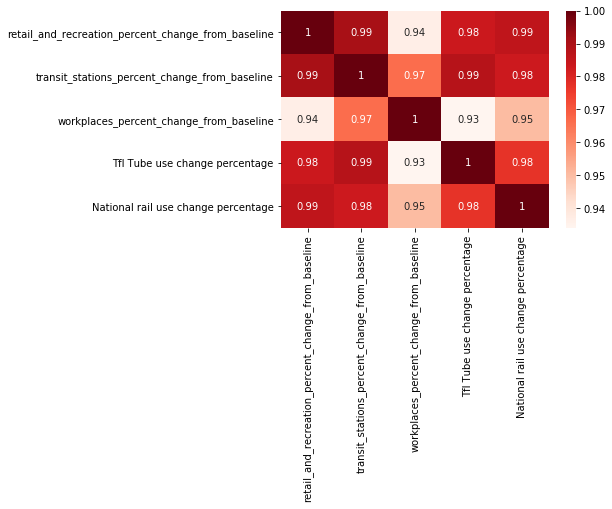

In [11]:
# look at the correlation coefficients of variables left
transport_corr_london_merged = df_london_merged.corr()
sns.heatmap(transport_corr_london_merged, annot=True, cmap=plt.cm.Reds)
plt.show()

## We can see that all the mobility variables left have a strong correlation with each other
Because `retail_and_recreation_percent_change_from_baseline` has a perfect correlation with National Rail Use and
`transit_stations_percent_change_from_baseline` a perfect correlation with TfL Ube Use, we would leave these variables to predict the use of two types of transport individually. 

The variable `workplaces_percent_change_from_baseline` seems redundant, since it is highly correlated with two other mobility features, but less correlated with Transport Use.

In [12]:
df_london_merged.drop(columns=['workplaces_percent_change_from_baseline'], inplace=True)

<Figure size 720x432 with 0 Axes>

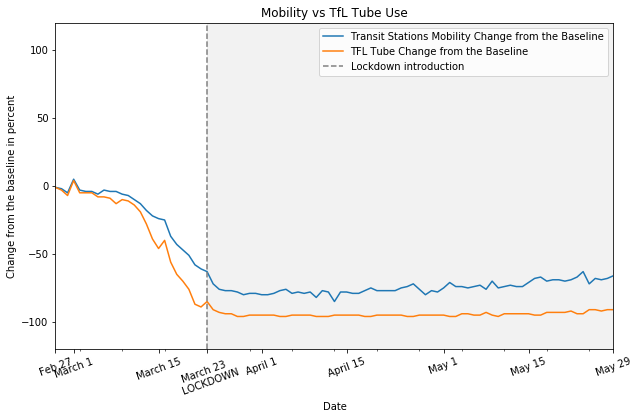

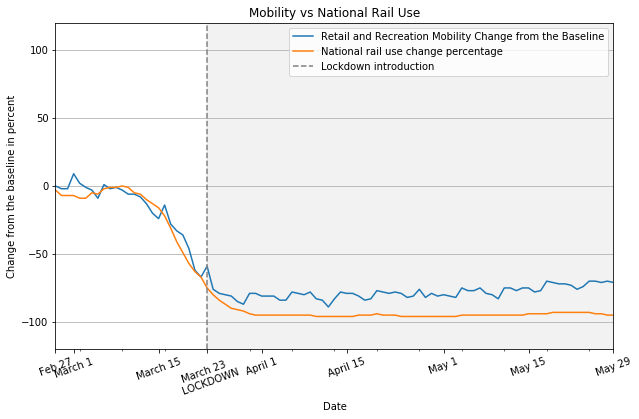

In [13]:
# plot the TfL Tube and National Rail with the most significant mobility features 
plt.figure(figsize = (10, 6))
ax = df_london_merged.plot(figsize = (10, 6), x='Date', y='transit_stations_percent_change_from_baseline', label = 'Transit Stations Mobility Change from the Baseline')
df_london_merged.plot(x='Date', y='Tfl Tube use change percentage', label = 'TFL Tube Change from the Baseline', ax=ax)
ax.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
ax.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
ax.set_ylabel('Change from the baseline in percent')
ax.set_xlabel('Date')
plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)
plt.title("Mobility vs TfL Tube Use")
plt.ylim(-120, 120)

fig = df_london_merged.plot(figsize = (10, 6), x='Date', y='retail_and_recreation_percent_change_from_baseline', label = 'Retail and Recreation Mobility Change from the Baseline')
df_london_merged.plot(x='Date', y='National rail use change percentage', label = 'National rail use change percentage', ax=fig)
fig.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
fig.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
fig.set_ylabel('Change from the baseline in percent')
fig.set_xlabel('Date')
plt.title("Mobility vs National Rail Use")


plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)
plt.ylim(-120, 120)
plt.grid(axis='y')
ax.legend()
fig.legend()
plt.show()


Both the correlation coefficient and graph shows that both **National Rail** and **TfL** use have a very strong correlation with certain mobility variables. The heatmap of correlation coefficients allowed us to choose the most significant predictor variable and avoid noise that comes from inter-correlation of mobility variables.

The graphs shows no huge spikes that could mark significant outliers in the data. Therefore, we cannot assume any signicant dataset errors.

Now, when we see that the data indeed has a strong correlation, build the prediction model.

## Implement and train machine learning models

Because of a limited size of the data, I decided not to use Deep Learning and try out ML Regression Models: Linear Regression, Polynomial Regression, and SV Regression.
As targets, I will use `National rail use change percentage` and `Tfl Tube use change percentage`


### Start with predicting TfL Tube Use change
Use `transit_stations_percent_change_from_baseline` as predictor, and `Tfl Tube use change percentage` as target.


### Split the Data into Training and Testing Sets
Prior to modeling, I first break our data into a training set and a test set to be able to evaluate how well the future model performs. I use scikit-learn's `train_test_split` function to do this split
Split columns of `df_london_merged` into predictor and target variables.


In [14]:
# Take out the values of the columns I want to work on
tfl_mob_predictor = df_london_merged[['Date','transit_stations_percent_change_from_baseline']].values
tfl_mob_target = df_london_merged['Tfl Tube use change percentage'].values
tfl_mob_predictor_train, tfl_mob_predictor_test, tfl_mob_target_train, tfl_mob_target_test = train_test_split(tfl_mob_predictor, tfl_mob_target, test_size = 0.25, random_state = 1)
# Create variables for training and testing the models
X = np.delete(tfl_mob_predictor_train, 0, 1)
y = tfl_mob_target_train
X_dates = tfl_mob_predictor_train[:, 0] # take out the Date column for further plotting

X_test = np.delete(tfl_mob_predictor_test, 0, 1)
X_test_dates = tfl_mob_predictor_test[:, 0]
y_test = tfl_mob_target_test

### Implement a Simple Linear Regression Model

In [15]:
# Fit Linear Regression to the dataset
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

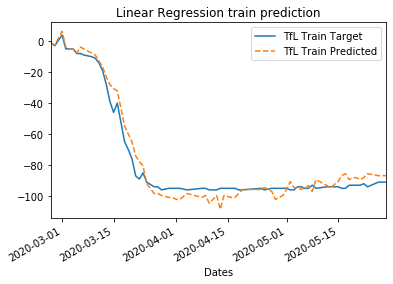

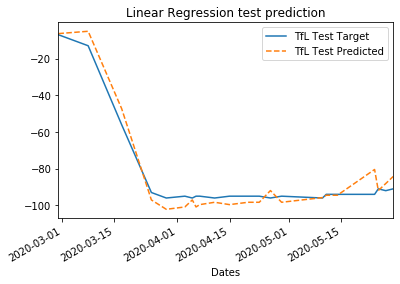

In [16]:
# plot Prediction against Target
train_predicted = linear_model.predict(X)
train_result = pd.DataFrame()
train_result["Dates"] = X_dates
train_result["Train_predicted"] = train_predicted
train_result["Train"] = y
ax = train_result.plot(x ='Dates', y='Train', kind = 'line', label='TfL Train Target')
train_result.plot(x ='Dates', y='Train_predicted', linestyle='dashed', kind = 'line', ax=ax, label='TfL Train Predicted')
plt.title('Linear Regression train prediction')

test_predicted = linear_model.predict(X_test)

test_result = pd.DataFrame()
test_result["Dates"] = X_test_dates
test_result["Test_predicted"] = test_predicted
test_result["Test"] = y_test
fig = test_result.plot(x ='Dates', y='Test', kind = 'line', label='TfL Test Target')
test_result.plot(x ='Dates', y='Test_predicted', linestyle='dashed', kind = 'line', label='TfL Test Predicted', ax=fig)
plt.title('Linear Regression test prediction')
# Score the model
score_tfl_mob_lyn = 'linearmodel test set R2:',linear_model.score(X_test,y_test)

### Implement a Polynomial Regression Model

In [17]:
# Fit the polynomial Regression
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)
X_poly_test = poly_features.fit_transform(X_test)
poly_linear_model = LinearRegression(normalize=True, fit_intercept=False)
poly_linear_model.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

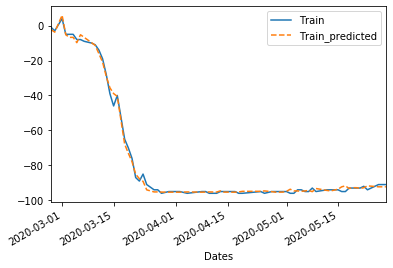

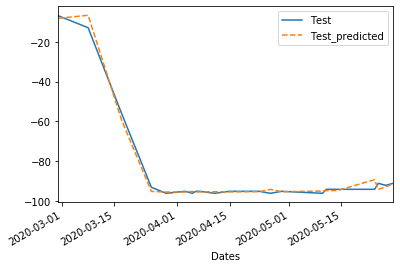

In [18]:
# plot Polyn. Regr. Prediction against Target 
train_predicted = poly_linear_model.predict(X_poly)
train_result = pd.DataFrame()
train_result["Dates"] = X_dates
train_result["Train_predicted"] = train_predicted
train_result["Train"] = y
ax = train_result.plot(x ='Dates', y='Train', kind = 'line')
train_result.plot(x ='Dates', y= 'Train_predicted', linestyle='dashed', kind = 'line', ax=ax)

test_predicted = poly_linear_model.predict(X_poly_test)
test_result = pd.DataFrame()
test_result["Dates"] = X_test_dates
test_result["Test_predicted"] = test_predicted
test_result["Test"] = y_test
fig = test_result.plot(x ='Dates', y='Test', kind = 'line')
test_result.plot(x ='Dates', y='Test_predicted', kind = 'line', linestyle='dashed',ax=fig)
# Score the model
score_tfl_mob_pln = 'polymodel test set R2:',poly_linear_model.score(X_poly_test,y_test)

### Implement a Support Vector Regression Model

In [19]:
# Fit the SV Regression
svrModel = SVR(epsilon=1)
svrModel.fit(X,y)
svr_train_predicted = svrModel.predict(X)

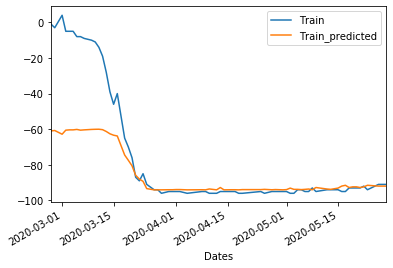

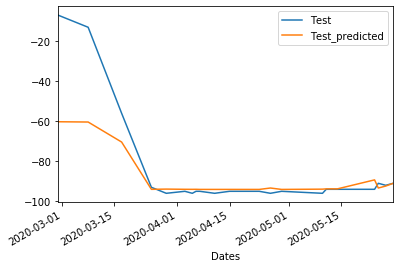

In [20]:
# plot SVR Prediction against Target 
svr_data = pd.DataFrame()
svr_data["Dates"] = X_dates
svr_data["Train"] = y
svr_data["Train_predicted"] = svr_train_predicted
svr_data.plot(x ='Dates', y=['Train','Train_predicted'], kind = 'line')
svr_test_predicted = svrModel.predict(X_test)

svr_test_data = pd.DataFrame()
svr_test_data["Dates"] = X_test_dates
svr_test_data["Test"] = y_test
svr_test_data["Test_predicted"] = svr_test_predicted
svr_test_data.plot(x ='Dates', y=['Test','Test_predicted'], kind = 'line')
# Score the model
score_tfl_mob_svr = 'linearmodel train set R2:',svrModel.score(X_test,y_test)

### Look at and Compare R2 Scores

In [21]:
print(score_tfl_mob_lyn)
print(score_tfl_mob_pln)
print(score_tfl_mob_svr)

('linearmodel test set R2:', 0.9551835120458505)
('polymodel test set R2:', 0.9930222636926597)
('linearmodel train set R2:', 0.6189199912169626)


We can see that the Polynomial Regression Model produces the best R2 score on **TfL Use Prediction**. 
Consequently, this model can be used to further predict Demand on TfL Tube in London.

### Predict National Rail Use
Use `retail_and_recreation_percent_change_from_baseline` as predictor, and `National rail use change percentage` as target.
Since the data for National Rail Use are analogous to those of TfL Tube, I am using the Polynomial Regression Model directly without testing other models.


### Split the Data into Training and Testing Sets
Prior to modeling, I again first break our data into a training set and a test set to be able to evaluate how well the future model performs. I use scikit-learn's `train_test_split` function to do this split of columns of `df_london_merged` into predictor and target variables.


In [22]:
# Take out the values of the columns I want to work on
rail_mob_predictor = df_london_merged[['Date','retail_and_recreation_percent_change_from_baseline']].values
rail_mob_target = df_london_merged['National rail use change percentage'].values
rail_mob_predictor_train, rail_mob_predictor_test, rail_mob_target_train, rail_mob_target_test = train_test_split(rail_mob_predictor, rail_mob_target, test_size = 0.25, random_state = 1)

# Create variables for training and testing the Polymodel
X = np.delete(rail_mob_predictor_train, 0, 1)
y = rail_mob_target_train
X_dates = rail_mob_predictor_train[:, 0] # take out the Date column for further plotting

X_test = np.delete(rail_mob_predictor_test, 0, 1)
X_test_dates = rail_mob_predictor_test[:, 0]
y_test = rail_mob_target_test

### Implement a Polynomial Regression Model

In [23]:
# Fit the polynomial Regression
poly_features = PolynomialFeatures(degree=4)
X_poly = poly_features.fit_transform(X)
X_poly_test = poly_features.fit_transform(X_test)
poly_linear_model = LinearRegression(normalize=True, fit_intercept=False)
poly_linear_model.fit(X_poly, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

('polymodel test set R2:', 0.9860334961967764)


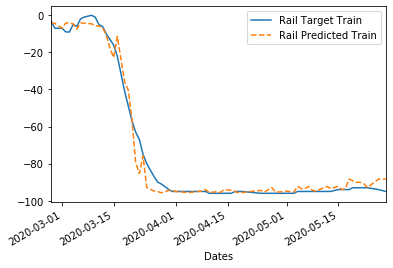

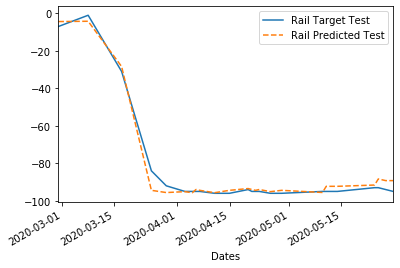

In [24]:
# plot Polyn. Regr. Prediction against Target 
train_predicted = poly_linear_model.predict(X_poly)
train_result = pd.DataFrame()
train_result["Dates"] = X_dates
train_result["Train_predicted"] = train_predicted
train_result["Train"] = y
ax = train_result.plot(x ='Dates', y='Train', kind = 'line', label='Rail Target Train')
train_result.plot(x ='Dates', y= 'Train_predicted', linestyle='dashed', kind = 'line', ax=ax, label='Rail Predicted Train')

test_predicted = poly_linear_model.predict(X_poly_test)
test_result = pd.DataFrame()
test_result["Dates"] = X_test_dates
test_result["Test_predicted"] = test_predicted
test_result["Test"] = y_test
fig = test_result.plot(x ='Dates', y='Test', kind = 'line', label='Rail Target Test')
test_result.plot(x ='Dates', y='Test_predicted', kind = 'line', linestyle='dashed',ax=fig, label='Rail Predicted Test')
# Score the model
score_rail_mob_pln = 'polymodel test set R2:',poly_linear_model.score(X_poly_test,y_test)
print(score_rail_mob_pln)

## Investigating the Relationship of COVID-19 Transport and Mobility change and New COVID-19 Cases

#### New Infection Cases
The first dataset used reflects daily new cases of COVID-19 worldwide and is maintained by **Our World in Data**:
https://ourworldindata.org/coronavirus-source-data

The second dataset used reflects daily new cases of COVID-19 in different regions of the UK and is maintained by **GOV.uk**:
https://coronavirus.data.gov.uk/

#### New Death Cases
The dataset reflecting daily new COVID-19 deaths in the United Kingdom is taken from https://coronavirus.data.gov.uk/

The dataset reflecting daily new COVID-19 deaths globally belongs to **European Centre for Disease Prevention and Control** https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases



In [139]:
# Import the COVID-19 cases data for London, world and the UK
path_new_cases = 'data/New_Cases.csv' # data for world and individual countries
path_new_cases_london = 'data/New_Cases_London.csv' # data for London

df_new_cases = pd.read_csv(path_new_cases, parse_dates = ['date'], dayfirst=True)
df_new_cases_london = pd.read_csv(path_new_cases_london, parse_dates = ['date'], dayfirst=True)
new_cases_london = df_new_cases_london[df_new_cases_london['Area name'] == 'London']
new_cases_london.head()

,Area name,Area code,Area type,date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases,Cumulative lab-confirmed cases rate
3,London,E12000007,Region,2020-06-08,0.0,NaN,NaN,27194,NaN,NaN,305.3
479,London,E12000007,Region,2020-06-07,11.0,NaN,NaN,27194,NaN,NaN,305.3
593,London,E12000007,Region,2020-06-06,13.0,NaN,NaN,27183,NaN,NaN,305.1
773,London,E12000007,Region,2020-06-05,22.0,NaN,NaN,27170,NaN,NaN,305.0
1034,London,E12000007,Region,2020-06-04,18.0,NaN,NaN,27148,NaN,NaN,304.8


In [140]:
# Import the new death cases data for England, world and the UK
path_uk_regions_death = 'data/Covid_Deaths_UK_Regions.csv' # data for deaths in United Kingdom
path_world_death = 'data/Covid_Deaths_Global.csv' # data for deaths in United Kingdom

In [141]:
# Read the data for UK regions
df_uk_regions_death = pd.read_csv(path_uk_regions_death, dayfirst=True).transpose()
# Clean the data for UK regions
df_uk_regions_death.drop(df_uk_regions_death.index[0], inplace=True)
df_uk_regions_death.columns = df_uk_regions_death.iloc[0]
df_uk_regions_death.columns.name = None
df_uk_regions_death.drop([df_uk_regions_death.index[0]], inplace=True)
df_uk_regions_death.drop([df_uk_regions_death.index[0]], inplace=True)
df_uk_regions_death.reset_index(level=0, inplace=True)
# Choose London as the region under analysis
df_london_death = df_uk_regions_death[['index', 'London']]
df_london_death.rename(columns={'index':'Date', 'London':'london_deaths'}, inplace=True)
df_london_death['Date'] = df_london_death['Date'][1:-10]
df_london_death['Date'] = pd.to_datetime(df_london_death['Date']) # put Date column into datatime format
df_london_death.drop(0, inplace=True)
df_london_death = df_london_death[df_london_death['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]

# Check for missing values
df_world_death.isna().any()

Date            False
world_deaths    False
uk_deaths       False
dtype: bool

In [142]:
# Look at the dataframe
df_london_death.head()

,Date,london_deaths
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,0
4,2020-03-04,0
5,2020-03-05,0


In [143]:
# Read the data for global deaths
df_world_death = pd.read_csv(path_world_death, parse_dates = ['date'], dayfirst=True)
# Choose the UK and world as regions analysis
df_world_death = df_world_death[['date','World','United Kingdom']]
df_world_death.rename(columns={'date':'Date', 'World':'world_deaths','United Kingdom':'uk_deaths'}, inplace=True)
df_world_death = df_world_death[df_world_death['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
# Check for missing values
df_world_death.isna().any()

Date            False
world_deaths    False
uk_deaths       False
dtype: bool

In [144]:
# Look at the dataframe
df_world_death.head()

,Date,world_deaths,uk_deaths
58,2020-02-27,38,0
59,2020-02-28,57,0
60,2020-02-29,62,0
61,2020-03-01,58,0
62,2020-03-02,67,0


In [145]:
# clean the data for the UK and whole world
# choose the dates under analysis
new_cases_world_uk = df_new_cases[['date', 'United Kingdom', 'World']]
new_cases_world_uk.rename(columns={'date':'Date', 'United Kingdom': 'new_cases_uk', 'World': 'new_cases_world'}, inplace=True)
new_cases_world_uk = new_cases_world_uk[new_cases_world_uk['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
new_cases_world_uk.head()

,Date,new_cases_uk,new_cases_world
58,2020-02-27,0,1109
59,2020-02-28,3,1269
60,2020-02-29,2,1848
61,2020-03-01,5,1819
62,2020-03-02,13,2079


In [146]:
# prepare the new cases data for London
# choose the London region and the dates under analysis
new_cases_london = new_cases_london[['date','Cumulative lab-confirmed cases']]
new_cases_london.rename(columns={'date':'Date', 'Cumulative lab-confirmed cases': 'new_cases_london'}, inplace=True)
new_cases_london.sort_values(by='Date', inplace=True)

# by the total count of cases, calculate the daily number of cases in 10s (for easy plotting)
new_cases_l = [0]
for n in range(1, len(new_cases_london)):
    current = new_cases_london['new_cases_london'].tolist()[n]
    previous = new_cases_london['new_cases_london'].tolist()[n-1]
    new_cases_l.append(current-previous)
new_cases_london['new_cases_london'] = new_cases_l
new_cases_london = new_cases_london[new_cases_london['Date'].isin(pd.date_range('2020-02-27', '2020-05-29'))]
new_cases_london.head()


,Date,new_cases_london
35807,2020-02-27,1
35778,2020-02-28,5
35767,2020-02-29,1
35709,2020-03-01,8
35649,2020-03-02,12


In [173]:
# merge the UK mobility and transport with new infection and death cases
df_cases_mobility = pd.merge(new_cases_london, new_cases_world_uk, how='left', on='Date')
df_cases_mobility = pd.merge(df_cases_mobility, df_london_death, how='left', on='Date')
df_cases_mobility = pd.merge(df_cases_mobility, df_world_death, how='left', on='Date')
df_cases_mobility = pd.merge(df_cases_mobility, df_london_merged, how='left', on='Date')

# check for missing values
df_cases_mobility.isna().any()

Date                                                  False
new_cases_london                                      False
new_cases_uk                                          False
new_cases_world                                       False
london_deaths                                          True
world_deaths                                          False
uk_deaths                                             False
retail_and_recreation_percent_change_from_baseline    False
transit_stations_percent_change_from_baseline         False
Tfl Tube use change percentage                        False
National rail use change percentage                   False
dtype: bool

We can observe missing values in the column `london_deaths` since the case registration for London started on March, 1. (There is no data for Feb 27-29). On Feb 27-29, no COVID death cases have yet been registered, so we can just fill the value with zero.

In [174]:
df_cases_mobility.fillna(value=0, inplace=True)

# check for missing values again
df_cases_mobility.isna().any()

Date                                                  False
new_cases_london                                      False
new_cases_uk                                          False
new_cases_world                                       False
london_deaths                                         False
world_deaths                                          False
uk_deaths                                             False
retail_and_recreation_percent_change_from_baseline    False
transit_stations_percent_change_from_baseline         False
Tfl Tube use change percentage                        False
National rail use change percentage                   False
dtype: bool

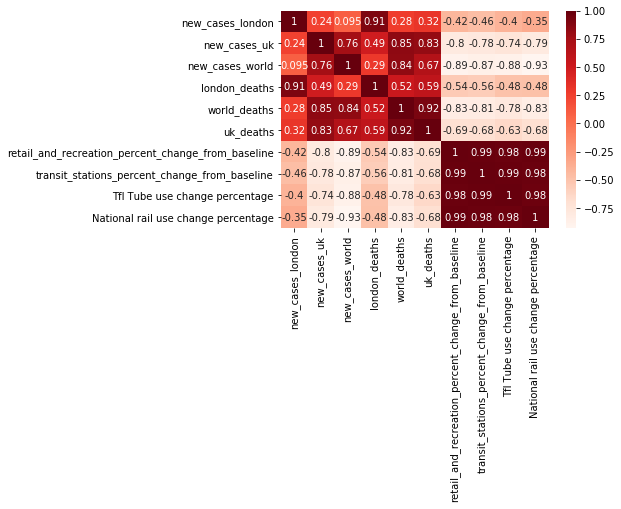

In [175]:
# look at the correlation of all variables
mobility_cases_corr = df_cases_mobility.corr()
sns.heatmap(mobility_cases_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

We can see that some infection variables have a very strong correlation with TfL Tube Use and National Rail Use

In [177]:
# Correlation of COVID cases with TfL Tube and National Rail
cor_cases_tube = abs(mobility_cases_corr[["Tfl Tube use change percentage", "National rail use change percentage"]])
cor_cases_tube

,Tfl Tube use change percentage,National rail use change percentage
new_cases_london,0.398572,0.349810
new_cases_uk,0.742857,0.794125
new_cases_world,0.877642,0.927698
london_deaths,0.484323,0.481486
world_deaths,0.783536,0.834590
uk_deaths,0.634489,0.684887
retail_and_recreation_percent_change_from_baseline,0.983282,0.986000
transit_stations_percent_change_from_baseline,0.988100,0.983194
Tfl Tube use change percentage,1.000000,0.977191
National rail use change percentage,0.977191,1.000000


Check the correlation of new cases with `retail_and_recreation` and `transit_stations` to see if it is more efficient to predict them than transport use directly

In [166]:
#Correlation of COVID cases with retail_and_recreation and transit_stations
cor_cases_retail_transit = abs(mobility_cases_corr[["retail_and_recreation_percent_change_from_baseline", "transit_stations_percent_change_from_baseline"]])
cor_cases_retail_transit.sort_values(["retail_and_recreation_percent_change_from_baseline", "transit_stations_percent_change_from_baseline"], ascending=[0, 1])

,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline
retail_and_recreation_percent_change_from_baseline,1.000000,0.991170
transit_stations_percent_change_from_baseline,0.991170,1.000000
National rail use change percentage,0.986000,0.983194
Tfl Tube use change percentage,0.983282,0.988100
new_cases_world,0.890155,0.866504
world_deaths,0.826518,0.814900
new_cases_uk,0.795168,0.777202
uk_deaths,0.693546,0.679299
london_deaths,0.540863,0.562729
new_cases_london,0.417974,0.463362


It is now clear that the direct correlation of `new_cases_world` and `world_deaths` with transport use is stronger, which means they can potentially be used to predict transport use directly.

## Multicollinearity
Check out the correlation structure between the predictor variables against multicollinearity.

In [183]:
# Choose the relevant variables
rel_cases_variables = df_cases_mobility[['new_cases_world', 'world_deaths']]
# look at the correlation coefficients of variables left
cases_variables_corr = rel_cases_variables.corr()
abs(cases_variables_corr['new_cases_world'])

new_cases_world    1.000000
world_deaths       0.835144
Name: new_cases_world, dtype: float64

The variables appear highly correlated (and their correlation is higher than that with transport use), so we can drop `new_cases_world` which appears to be more relevant to both transport use variables.

In [129]:
# look at the correlation with New Cases in London
cor_london = abs(mobility_corr["new_cases_london"])
cor_london

new_cases_london                                      1.000000
new_cases_uk                                          0.242351
new_cases_world                                       0.094919
retail_and_recreation_percent_change_from_baseline    0.417974
transit_stations_percent_change_from_baseline         0.463362
Tfl Tube use change percentage                        0.398572
National rail use change percentage                   0.349810
Name: new_cases_london, dtype: float64

#### It can be observed that New daily cases in the whole world have much stronger correlation with both mobility and transport, so we can just drop other variables.

In [130]:
df_cases_mobility.drop(columns=['new_cases_london', 'new_cases_uk'], inplace=True)
df_cases_mobility.head()

,Date,new_cases_world,London,retail_and_recreation_percent_change_from_baseline,transit_stations_percent_change_from_baseline,Tfl Tube use change percentage,National rail use change percentage
0,2020-02-27,1109,NaN,0.0,-1.0,-1,-3
1,2020-02-28,1269,NaN,-2.0,-2.0,-3,-7
2,2020-02-29,1848,NaN,-2.0,-5.0,-7,-7
3,2020-03-01,1819,0,9.0,5.0,4,-7
4,2020-03-02,2079,0,2.0,-3.0,-5,-9


In [131]:
# for easier plotting, divide the number of new cases in the world by 1000


KeyError: 'plot_new_cases_world'

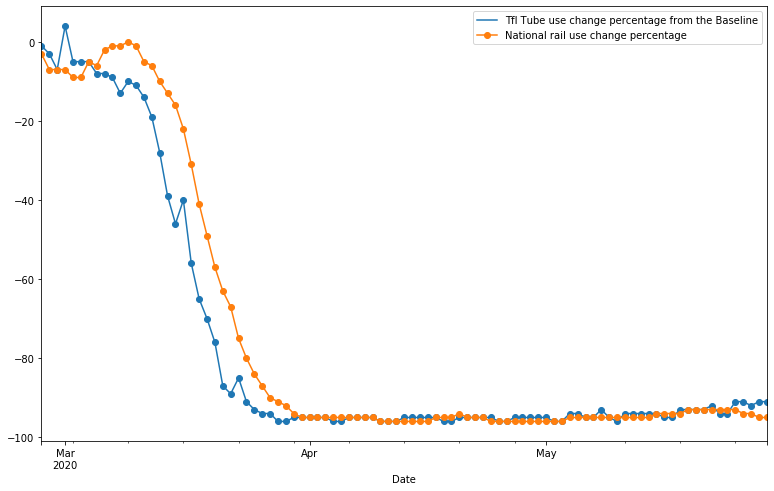

In [132]:
# plot new daily cases in the world on one graph
fig = df_cases_mobility.plot(figsize = (13, 8), x='Date', y='Tfl Tube use change percentage', label = 'Tfl Tube use change percentage from the Baseline', marker = 'o')
df_cases_mobility.plot(x='Date', y='National rail use change percentage', label = 'National rail use change percentage', ax=fig, marker = 'o')
df_cases_mobility.plot(x='Date', y='plot_new_cases_world', label = 'New Cases in the world in 1000s', ax=fig, marker = 'o', color='red')
fig.axvline(x='2020-03-23', color='gray', linestyle='--', label = 'Lockdown introduction')
fig.set_ylabel('Change from the baseline in percent')
fig.set_xlabel('Date')
fig.axvspan('2020-03-23', '2020-05-29', alpha=0.1, color='gray')
plt.title("New Cases in the world vs Transport Use")
plt.ylim(-130, 130)
plt.xticks(['2020-02-27', '2020-03-01', '2020-03-15', '2020-03-23', '2020-04-01', '2020-04-15', '2020-05-01', '2020-05-15', '2020-05-29'], ['Feb 27', 'March 1', 'March 15', 'March 23 \n LOCKDOWN', 'April 1', 'April 15', 'May 1', 'May 15', 'May 29'],rotation=20)

plt.grid(axis='y')
ax.legend()
fig.legend()
plt.show()

Again, we can observe quite a strong correlation of New Daily Cases with transport use.

The graph shows no huge spikes that mark significant outliers in the data. Therefore, we cannot assume any signicant dataset errors.